In [1]:
#Leer el archivo results.txt linea por linea
import json
import seaborn as sns
import matplotlib.pyplot as plt

from lcp.src.problems.problems import Problems
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300


results = []
with open('results.txt', 'r', encoding='utf-8', newline='\n') as r: 
    for line in r:
        json_line = json.loads(line)
        results.append(json_line)
        
problems = {}
for i in [5,10,20]:
    ps = Problems(file_path='problems/types_%d.json' % i).load_problems()
    for p in ps:
        if i not in problems:
            problems[i] = {}
        problems[i][p.id] = p

mejoras = {
    "none": "M0",
    "during":"M1",
    "late_all":"M2",
    "late_some":"M3",
    "late_best":"M4"
}

winners = {}

In [2]:
import numpy as np

improvements = {

}
for r in results:
    types_count = r['types_count']
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in improvements:
        improvements[types_count] = {}
    if group_improvement not in improvements[types_count]:
        improvements[types_count][group_improvement] = []
    improvements[types_count][group_improvement].append(
        100*(r['best_value'][0]/r['default_max_fitness'][0]-1))

for i, im in improvements.items():
    for j in improvements[i]:
        improvements[i][j] = [round(np.mean(improvements[i][j]), 1), round(
            np.std(improvements[i][j]), 1)]
    print(("%dT & " % i) + " & ".join(["%s\\%% & %s" % (x, y)
          for x, y in improvements[i].values()]) + " \\\\ \\hline")
# improvements

5T & 12.8\% & 5.9 & 13.3\% & 5.8 & 13.4\% & 5.8 & 12.9\% & 5.9 & 13.0\% & 5.8 \\ \hline
10T & 17.1\% & 8.2 & 19.9\% & 8.7 & 19.5\% & 8.5 & 17.5\% & 8.2 & 18.2\% & 8.0 \\ \hline
20T & 26.2\% & 7.7 & 33.1\% & 7.6 & 32.0\% & 7.0 & 27.8\% & 7.8 & 29.0\% & 6.9 \\ \hline
30T & 28.4\% & 9.3 & 39.0\% & 8.8 & 38.5\% & 8.8 & 36.8\% & 9.0 & 31.8\% & 9.0 \\ \hline
40T & 34.9\% & 9.9 & 50.0\% & 9.6 & 48.5\% & 10.4 & 47.4\% & 10.0 & 41.0\% & 10.1 \\ \hline


In [3]:
timings = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in timings:
        timings[types_count] = {}
    if group_improvement not in timings[types_count]:
        timings[types_count][group_improvement] = []
    timings[types_count][group_improvement].append(r['best']['best_time'])

timings_text = {}
for i, im in timings.items():
    for j in timings[i]:
        if i not in timings_text:
            timings_text[i] = {}
        if j not in timings_text[i]:
            timings_text[i][j] = []
        timings_text[i][j] = [round(np.mean(timings[i][j]), 1), round(
            np.std(timings[i][j]), 1)]
    print(("%s & " % i) + " & ".join(["%s & %s" % (x, y)
         for x, y in timings_text[i].values()]) + " \\\\ \\hline")
#timings

5T & 71.4 & 65.4 & 25.6 & 48.5 & 50.4 & 55.8 & 48.4 & 41.9 & 56.6 & 65.9 \\ \hline
10T & 126.5 & 73.1 & 48.3 & 58.9 & 87.1 & 90.7 & 96.3 & 78.9 & 96.5 & 70.3 \\ \hline
20T & 217.7 & 71.8 & 127.6 & 64.9 & 148.5 & 77.7 & 213.8 & 71.6 & 191.1 & 74.4 \\ \hline
30T & 248.8 & 48.8 & 179.3 & 71.1 & 219.1 & 59.3 & 198.1 & 68.3 & 222.5 & 52.9 \\ \hline
40T & 267.6 & 23.2 & 218.7 & 73.7 & 230.3 & 49.2 & 236.0 & 61.5 & 234.3 & 48.4 \\ \hline


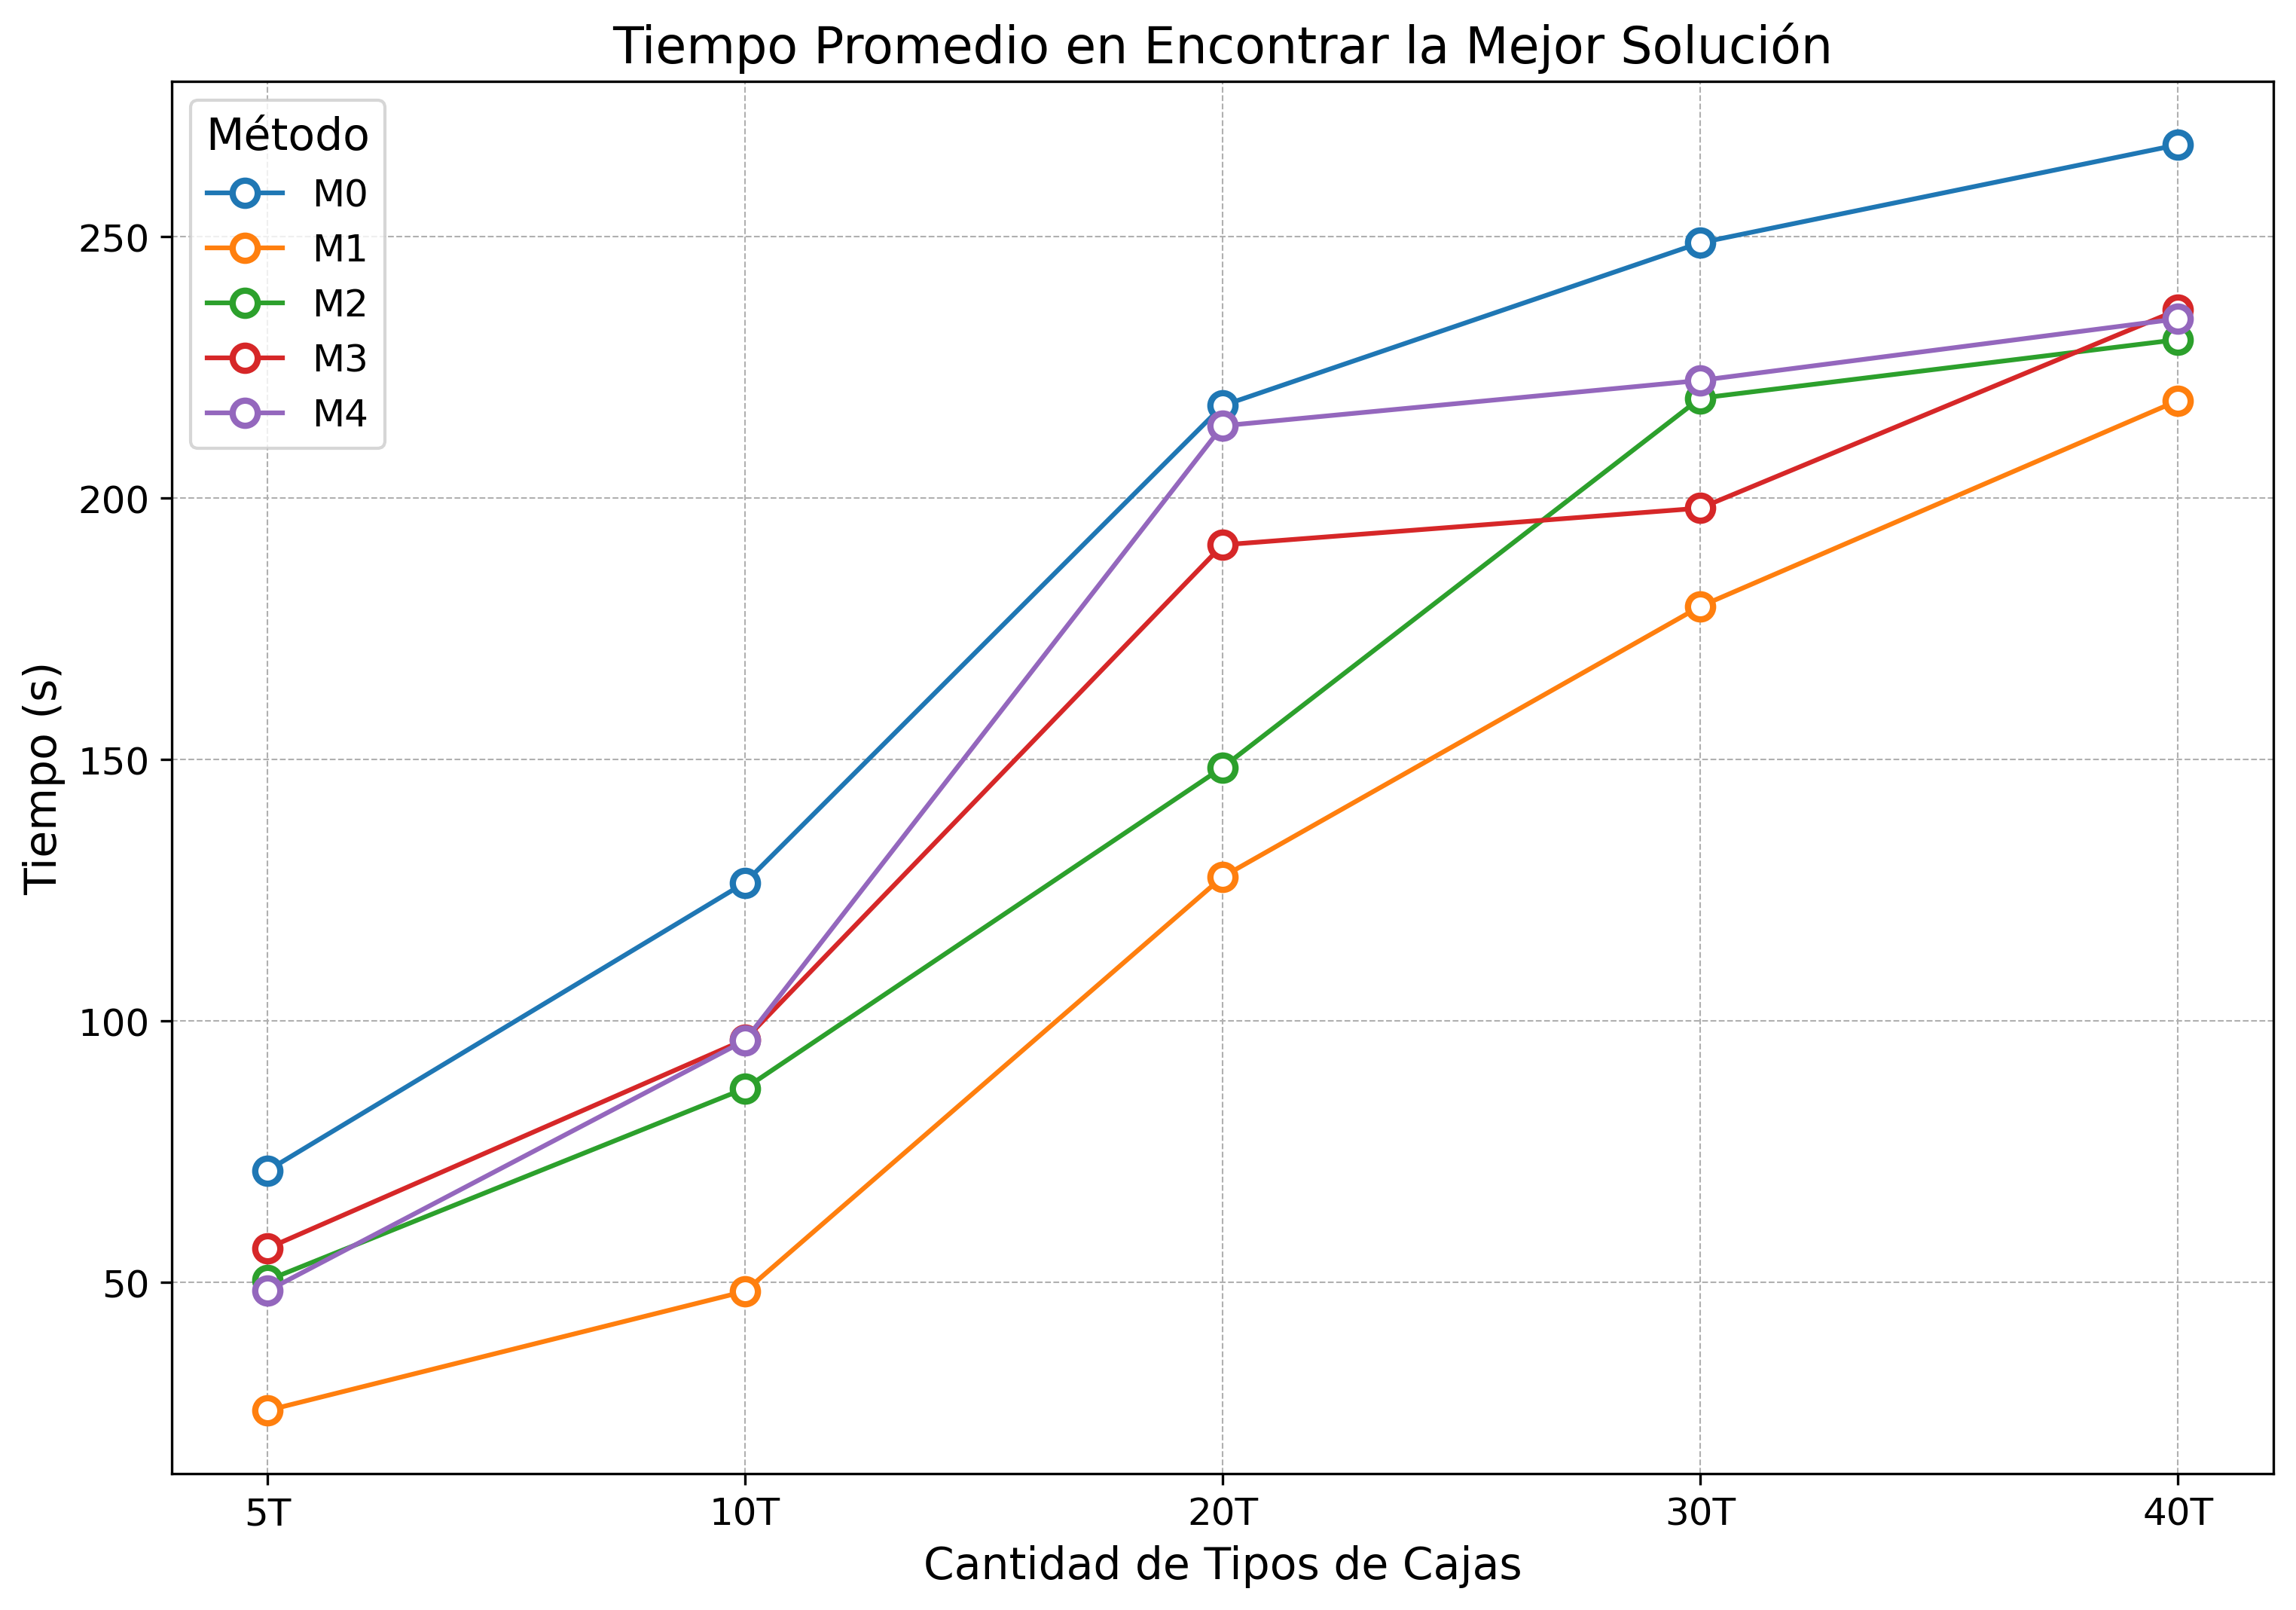

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que los datos están en la variable `timings`
data = timings

# Inicializar listas para el eje x (claves) y el eje y (promedios)
x = list(data.keys())
none_averages = [np.mean(data[k]['M0']) for k in x]
during_averages = [np.mean(data[k]['M1']) for k in x]
late_all_averages = [np.mean(data[k]['M2']) for k in x]
late_best_averages = [np.mean(data[k]['M3']) for k in x]
late_some_averages = [np.mean(data[k]['M4']) for k in x]

# Definir colores para cada serie
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Plotear los datos con mejoras estéticas
plt.plot(x, none_averages, label='M0', marker='o', linestyle='-', color=colors[0], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, during_averages, label='M1', marker='o', linestyle='-', color=colors[1], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_all_averages, label='M2', marker='o', linestyle='-', color=colors[2], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_best_averages, label='M3', marker='o', linestyle='-', color=colors[3], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_some_averages, label='M4', marker='o', linestyle='-', color=colors[4], markersize=8, markerfacecolor='white', markeredgewidth=2)

# Añadir títulos y etiquetas con mayor detalle
plt.title('Tiempo Promedio en Encontrar la Mejor Solución', fontsize=16)
plt.xlabel('Cantidad de Tipos de Cajas', fontsize=14)
plt.ylabel('Tiempo (s)', fontsize=14)

# Añadir la leyenda
plt.legend(title='Método', fontsize=12, title_fontsize=14)

# Añadir rejilla con estilo
plt.grid(True, linestyle='--', linewidth=0.5)

# Mejorar la visualización de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./lcp/document/Figures/tiempos.svg', format='svg')
# Mostrar el gráfico
plt.show()
#Guardar el svg


In [5]:
performance = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in performance:
        performance[types_count] = {}
    if group_improvement not in performance[types_count]:
        performance[types_count][group_improvement] = []
    performance[types_count][group_improvement].append((100*(r['best_value'][0]/r['default_max_fitness'][0]-1))/r['best']['best_time'])

performance_text = {}
for i, im in performance.items():
    for j in performance[i]:
        if i not in performance_text:
            performance_text[i] = {}
        if j not in performance_text[i]:
            performance_text[i][j] = []
        performance_text[i][j] = [round(np.mean(performance[i][j]), 1), round(
            np.std(performance[i][j]), 1)]
#performance_text

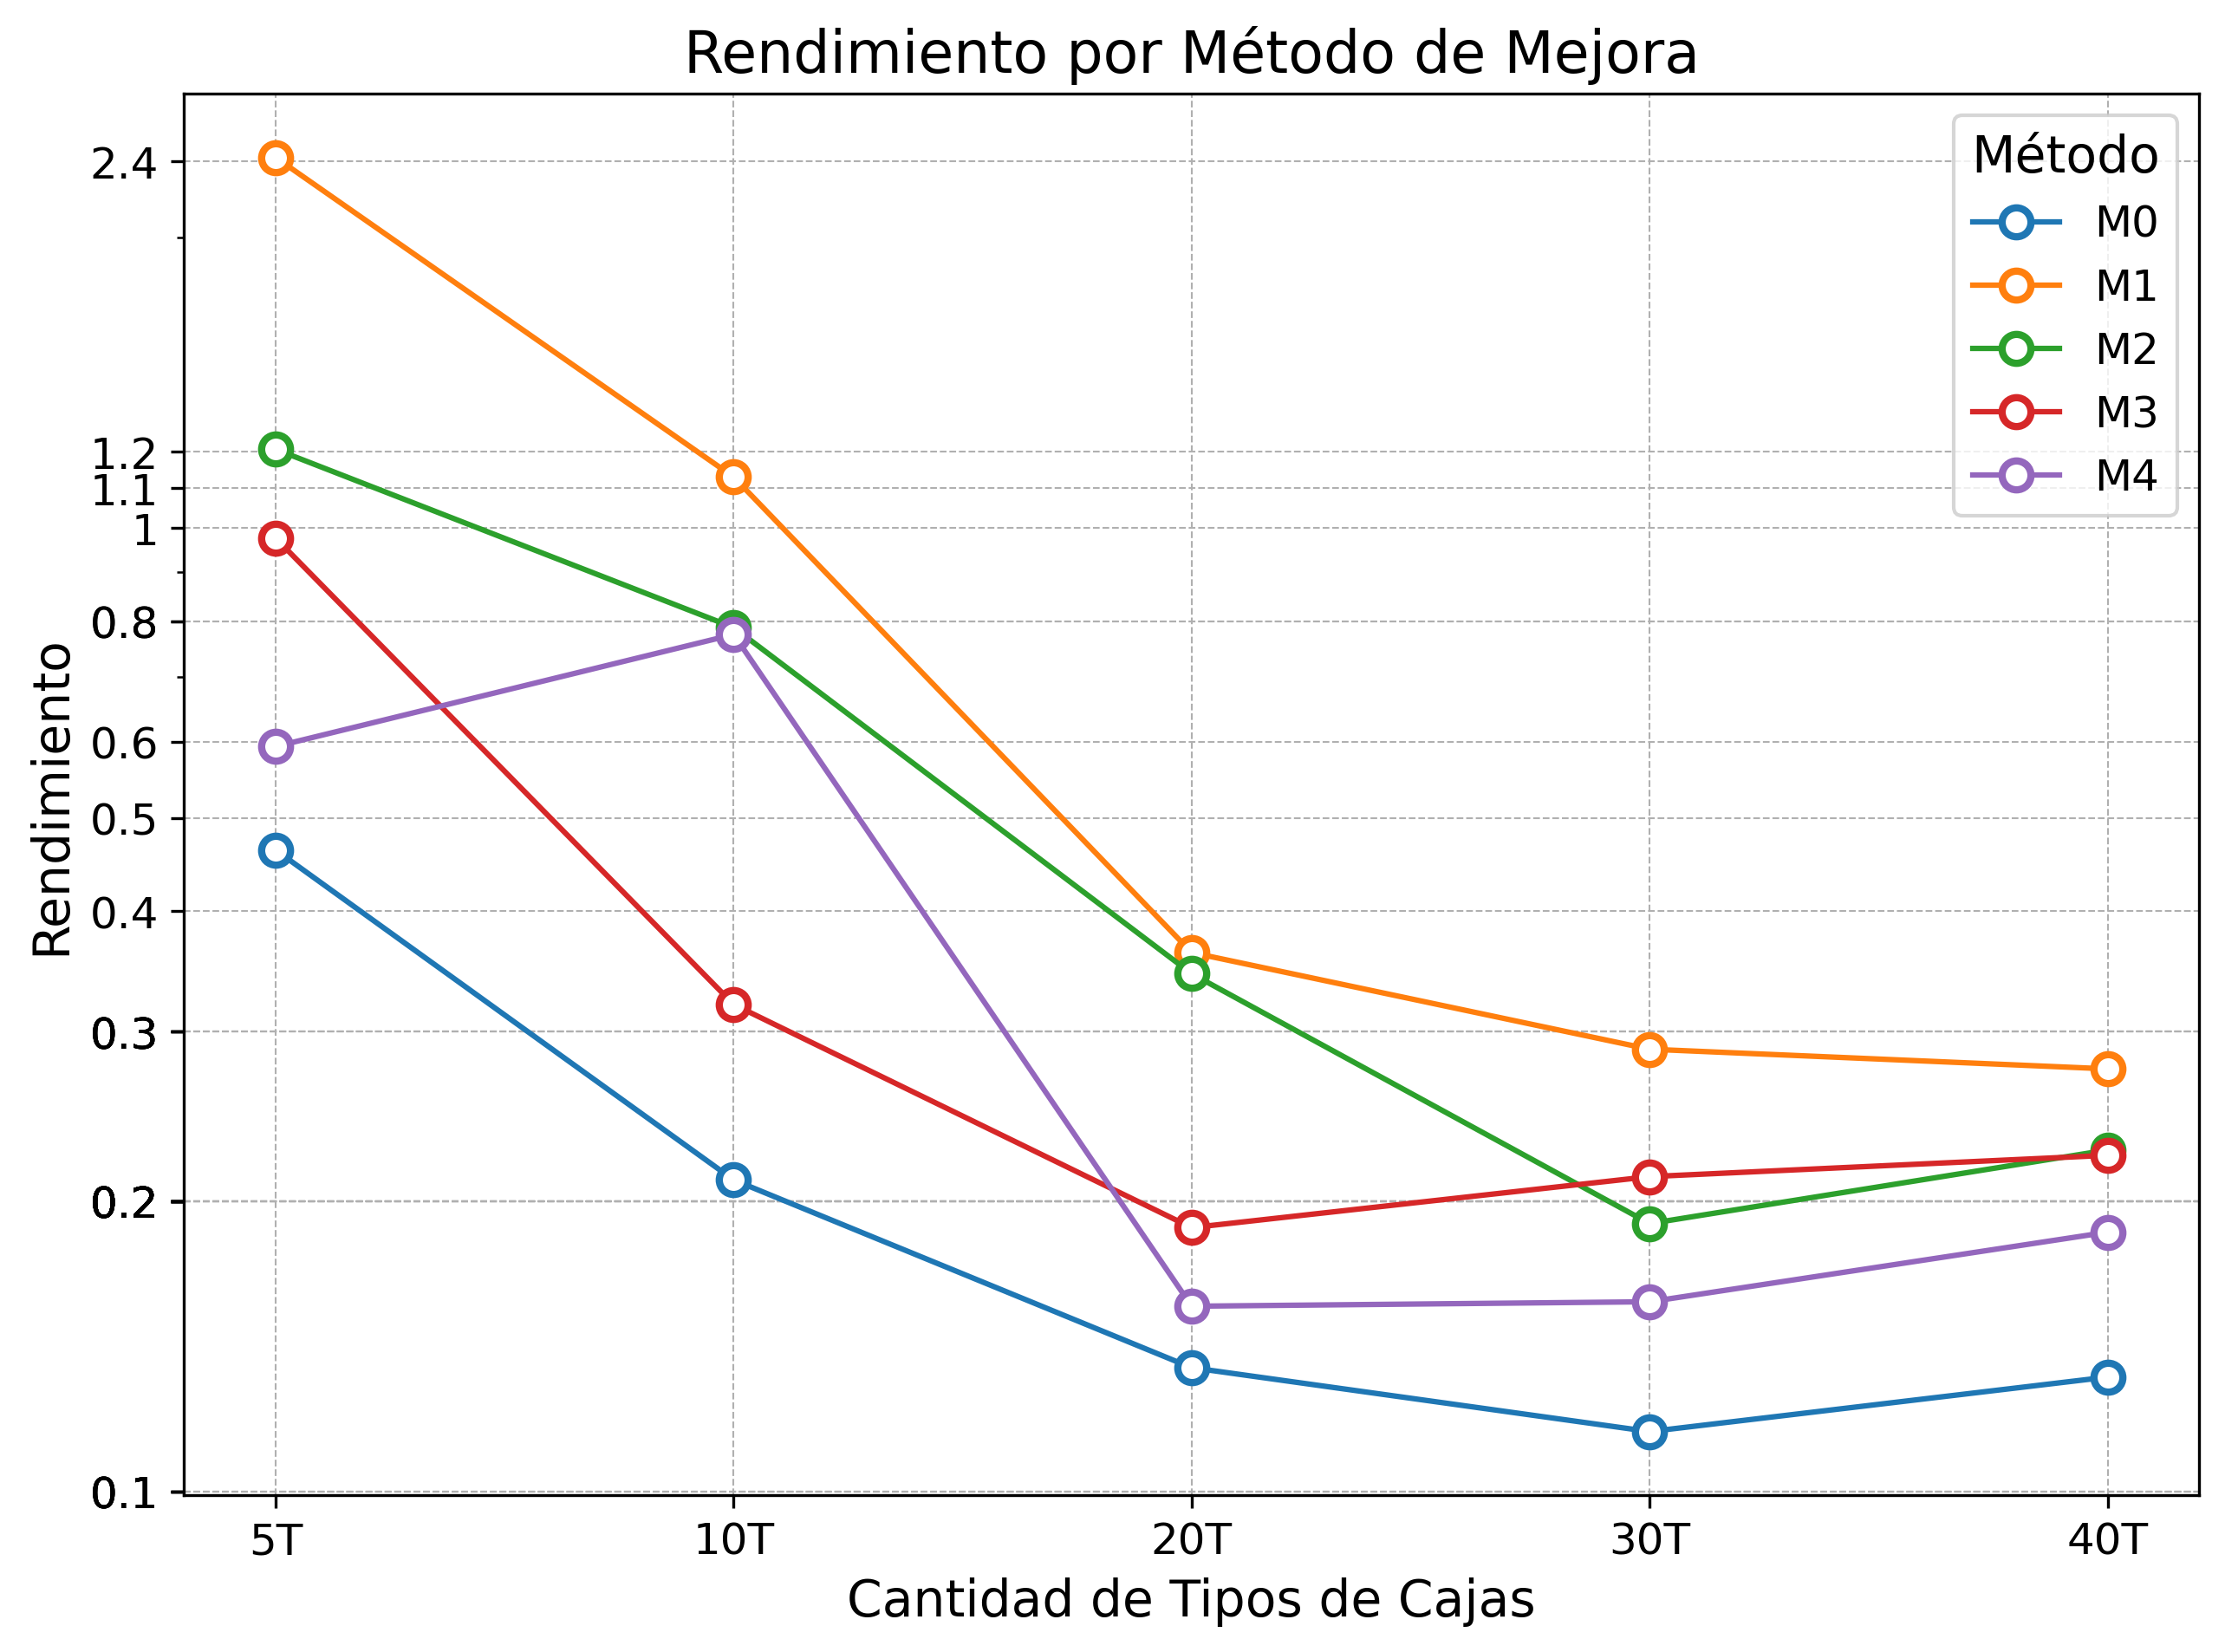

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Suponiendo que los datos están en la variable `timings`
data = performance

# Inicializar listas para el eje x (claves) y el eje y (promedios)
x = list(data.keys())
none_averages = [np.mean(data[k]['M0']) for k in x]
during_averages = [np.mean(data[k]['M1']) for k in x]
late_all_averages = [np.mean(data[k]['M2']) for k in x]
late_best_averages = [np.mean(data[k]['M3']) for k in x]
late_some_averages = [np.mean(data[k]['M4']) for k in x]

# Definir colores para cada serie
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 7))

# Plotear los datos con mejoras estéticas
ax.plot(x, none_averages, label='M0', marker='o', linestyle='-', color=colors[0], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, during_averages, label='M1', marker='o', linestyle='-', color=colors[1], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_all_averages, label='M2', marker='o', linestyle='-', color=colors[2], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_best_averages, label='M3', marker='o', linestyle='-', color=colors[3], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_some_averages, label='M4', marker='o', linestyle='-', color=colors[4], markersize=8, markerfacecolor='white', markeredgewidth=2)

# Añadir títulos y etiquetas con mayor detalle
ax.set_title('Rendimiento por Método de Mejora', fontsize=16)
ax.set_xlabel('Cantidad de Tipos de Cajas', fontsize=14)
ax.set_ylabel('Rendimiento', fontsize=14)

# Añadir la leyenda
ax.legend(title='Método', fontsize=12, title_fontsize=14)

# Añadir rejilla con estilo
ax.grid(True, linestyle='--', linewidth=0.5)

# Mejorar la visualización de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Hacer el eje y logarítmico
ax.set_yscale("log")

# Cambiar las etiquetas del eje y a su forma exponencial
formatter = ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
# Obtener los valores y de los puntos
y_values = [0.1] + none_averages + during_averages + late_all_averages + late_best_averages + late_some_averages
# Usar la función set_yticks para establecer los ticks en el eje y
ax.set_yticks([round(y,1) for y in y_values])
plt.savefig('./lcp/document/Figures/rendimiento.svg', format='svg')
# Mostrar el gráfico
plt.show()
#Guardar el svg


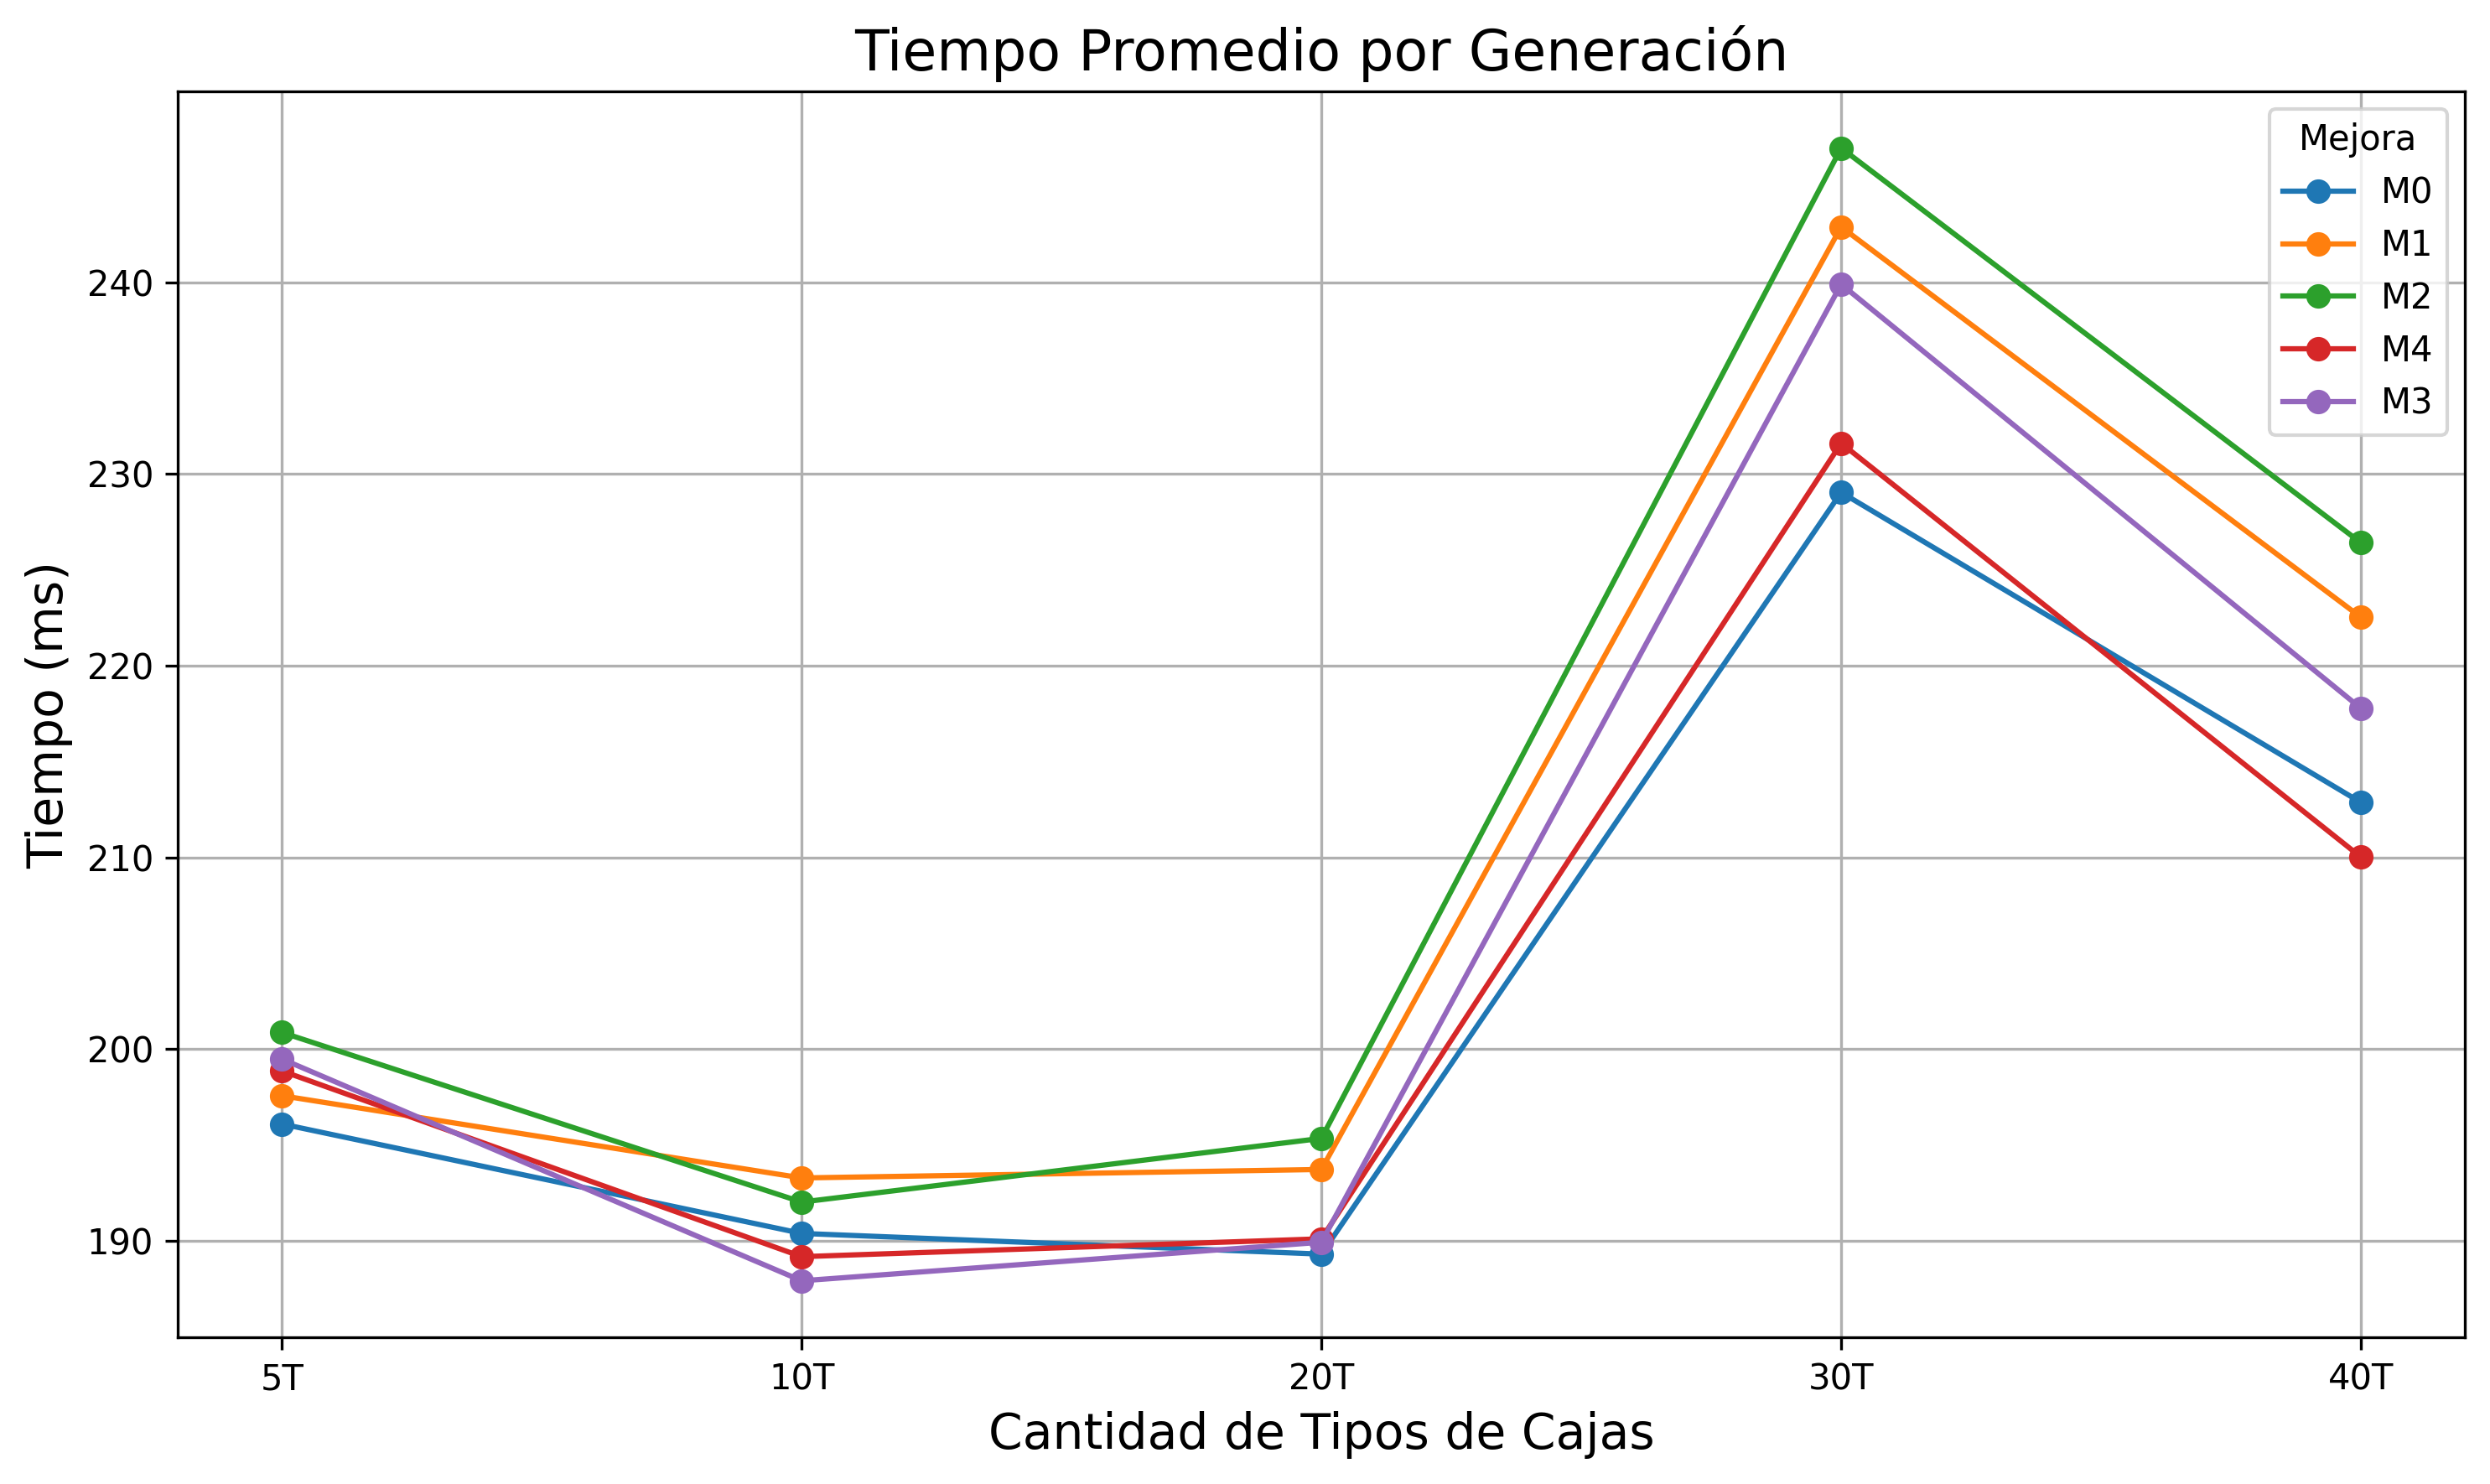

In [7]:
tiempo_iteracion = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in tiempo_iteracion:
        tiempo_iteracion[types_count] = {}
    if group_improvement not in tiempo_iteracion[types_count]:
        tiempo_iteracion[types_count][group_improvement] = []
    tiempo_iteracion[types_count][group_improvement].append(1000*r['timings']['duration']/r['generations'])
for t in tiempo_iteracion:
    for m in tiempo_iteracion[t]:
        tiempo_iteracion[t][m] = np.mean(tiempo_iteracion[t][m])

import matplotlib.pyplot as plt

# Datos proporcionados
data = tiempo_iteracion

# Preparar los datos para el gráfico
categories = list(data.keys())
subcategories = list(data[categories[0]].keys())

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

for subcategory in subcategories:
    values = [data[category][subcategory] for category in categories]
    plt.plot(categories, values, marker='o', label=subcategory)

# Añadir título y etiquetas
plt.title('Tiempo Promedio por Generación', fontsize=16)
plt.xlabel('Cantidad de Tipos de Cajas', fontsize=14)
plt.ylabel('Tiempo (ms)', fontsize=14)
plt.legend(title='Mejora')
plt.grid(True)
plt.tight_layout()

plt.savefig('./lcp/document/Figures/tiempo_generacion.svg', format='svg')
# Mostrar el gráfico
plt.show()


In [8]:
result = results[300]
problem = problems[result['types_count']][result['problem_id']]
box_types = problem.box_types
best_solution = result['best_solution']
box_types,best_solution

([BoxType(length=542, width=266, height=469, type=0, min_count=0, max_count=49, value_individual=62, weight=62),
  BoxType(length=545, width=257, height=355, type=1, min_count=0, max_count=66, value_individual=60, weight=60),
  BoxType(length=666, width=501, height=671, type=2, min_count=0, max_count=14, value_individual=36, weight=36),
  BoxType(length=584, width=665, height=332, type=3, min_count=0, max_count=25, value_individual=5, weight=5),
  BoxType(length=516, width=500, height=417, type=4, min_count=0, max_count=30, value_individual=10, weight=10),
  BoxType(length=377, width=737, height=737, type=5, min_count=0, max_count=16, value_individual=96, weight=96),
  BoxType(length=434, width=272, height=465, type=6, min_count=0, max_count=60, value_individual=18, weight=18),
  BoxType(length=558, width=431, height=445, type=7, min_count=0, max_count=31, value_individual=54, weight=54),
  BoxType(length=395, width=673, height=595, type=8, min_count=0, max_count=21, value_individual=3

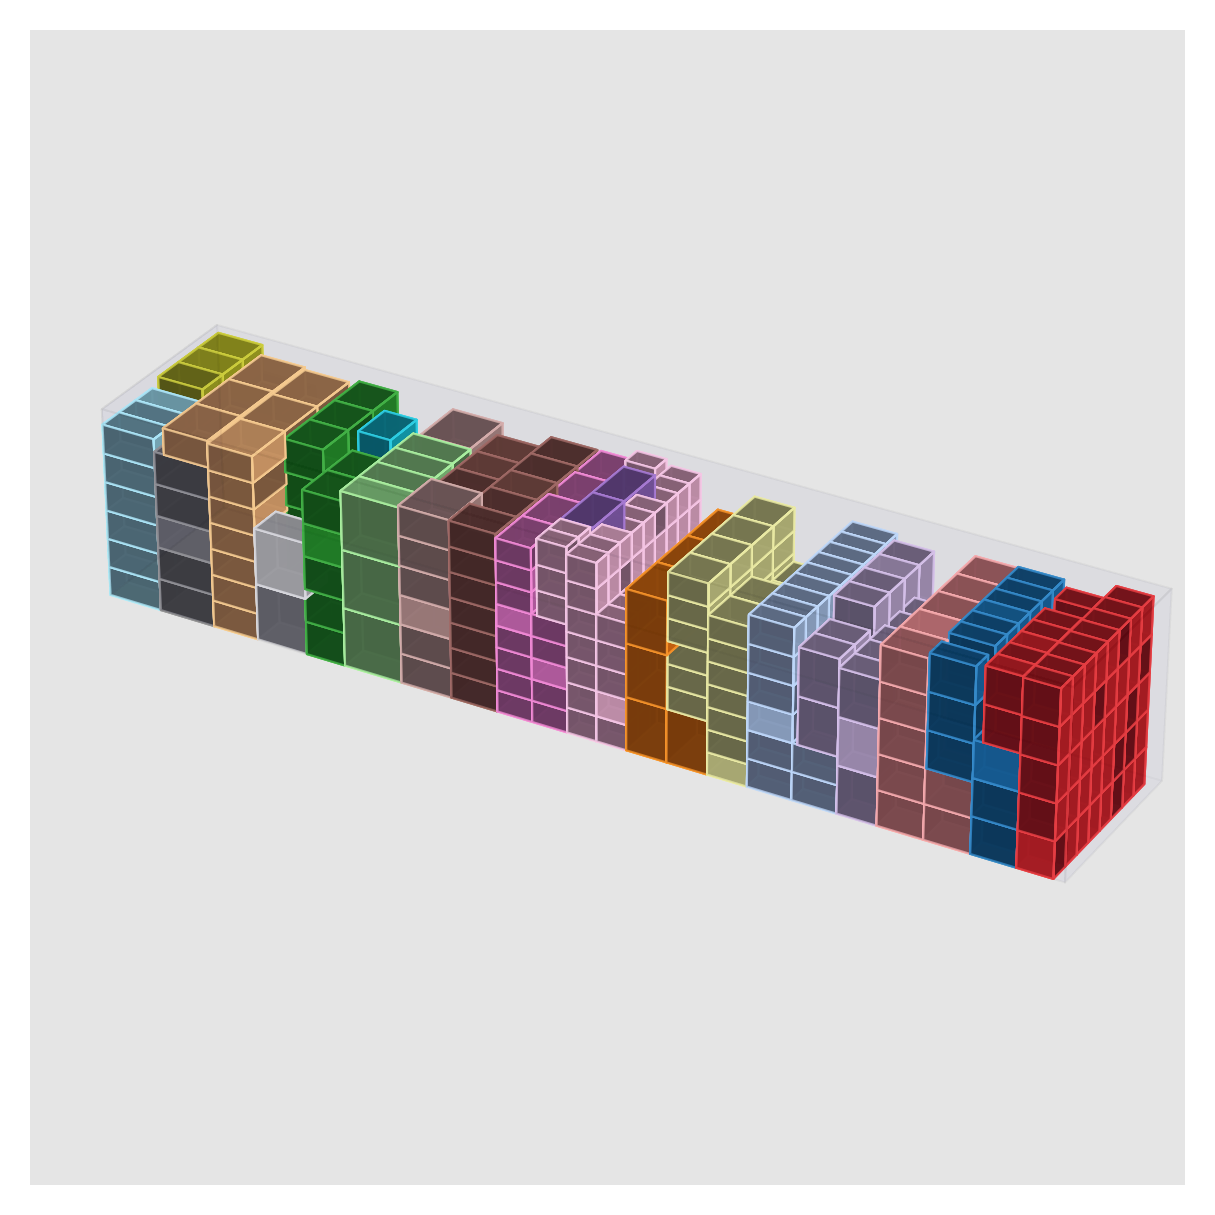

In [9]:
from lcp.src.algorithm.chromosome import Chromosome, Improvement
from lcp.src.algorithm.gene import Gene
from lcp.src.graphic.draw_container import draw

group_improvement = result['group_improvement']

genes = [Gene(type=box_types[b[0]], box_count=b[1], rotation=b[2])
         for b in best_solution]
e = Chromosome(genes=genes, container=problem.container)
imp = Improvement.during if group_improvement == 'during' else Improvement.none
e.evaluate(improvement=imp)
if group_improvement in ['late_all', 'late_best', 'late_some']:
    e.evaluate_with_improvement_late()

draw(e.result, '', problem.container)

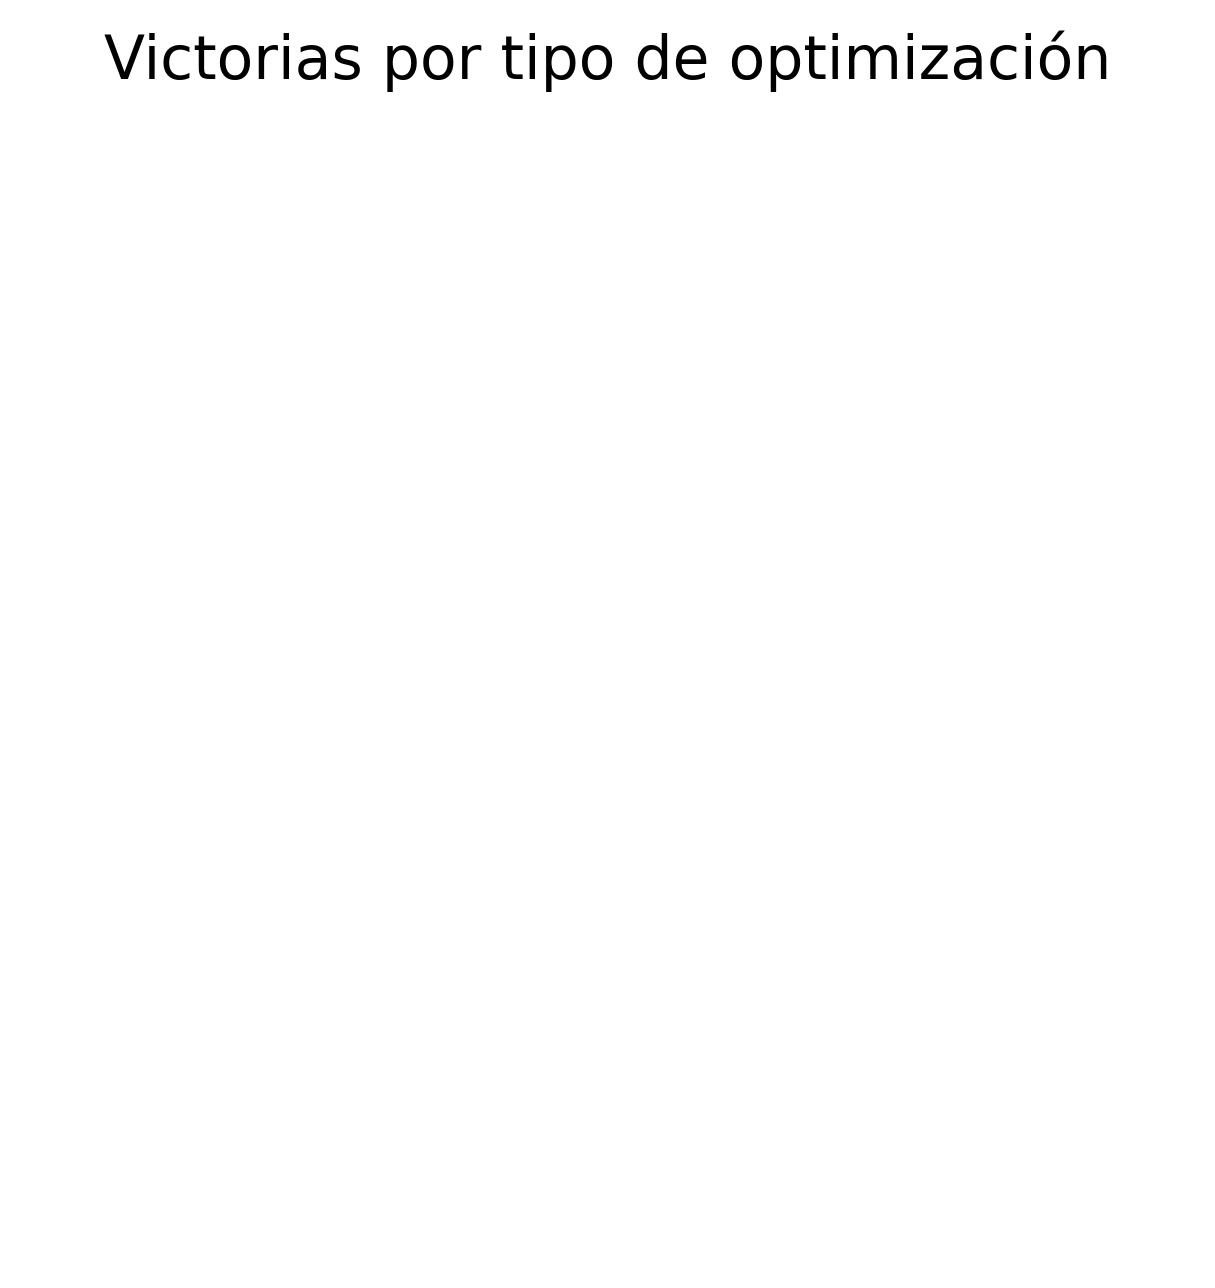

In [10]:
fig, ax = plt.subplots()
ax.pie([sum(w) for w in winners.values()],
       labels=winners.keys(), autopct='%1.1f%%')
ax.set_title('Victorias por tipo de optimización')
plt.show()

In [11]:
tipos_mejora = list(winners.keys())
cantidad_configuraciones = len(winners['none'])

# Graficar
fig, ax = plt.subplots()

# Iterar sobre cada tipo de mejora y graficar sus valores
for i, tipo in enumerate(tipos_mejora):
    ax.bar([x + i*0.15 for x in range(cantidad_configuraciones)],
           winners[tipo], width=0.15, label=tipo)

# Configurar ejes y leyenda
ax.set_xticks([x + 0.3 for x in range(cantidad_configuraciones)])
ax.set_xticklabels(
    [f'{(i+1)*5}T' for i in range(cantidad_configuraciones)])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Cantidad de victorias')
ax.set_title('Cantidad de victorias por tipo de mejora y tipos de cajas')
ax.legend()

# Mostrar el gráfico
plt.show()

KeyError: 'none'

In [ ]:
types_count = {
    5: [],
    10: [],
    20: [],
}
for r in results:
    types_count[r['types_count']].append(r['generations'])

fig, ax = plt.subplots()
sns.boxplot(data=[types_count[5], types_count[10],
            types_count[20]])
ax.set_xticks(range(5))
ax.set_xticklabels(["5 Tipos", "10 Tipos", "20 Tipos", "30 Tipos", "40 Tipos"])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Generaciones')
ax.set_title('Distribución de generaciones por Tipos de cajas')
plt.show()

In [ ]:
types_count = {
    "none": [],
    "during": [],
    "late_all": [],
    "late_best": [],
    "late_some": []
}

for r in results:
    types_count[r['group_improvement']].append(r['generations'])

fig, ax = plt.subplots()
sns.boxplot(data=[types_count["none"], types_count["during"], types_count["late_all"], types_count["late_best"], types_count["late_some"]])
ax.set_xticks(range(5))
ax.set_xticklabels(["Ninguna", "Durante", "Todas al final", "Mejor al final", "Algunas al final"])
ax.set_xlabel('Tipo de mejora')
ax.set_ylabel('Generaciones')
ax.set_title('Distribución de generaciones por Tipo de Mejora')
plt.show()

In [ ]:
types_count = {
    "none": [],
    "during": [],
    "late_all": [],
    "late_best": [],
    "late_some": []
}

for r in results:
    for t in r['timings']['generations_time']:
        types_count[r['group_improvement']].append(t)

fig, ax = plt.subplots()
sns.boxplot(data=[types_count["none"], types_count["during"], types_count["late_all"], types_count["late_best"], types_count["late_some"]])
ax.set_xticks(range(5))
ax.set_xticklabels(["Ninguna", "Durante", "Todas al final", "Mejor al final", "Algunas al final"])
ax.set_xlabel('Tipo de mejora')
ax.set_ylabel('Tiempo por generación (ms)')
ax.set_title('Distribución de tiempo por generación por tipo de mejora')
plt.show()

In [ ]:
# Cantidad de cajas por tipo de caja

types_count = {
    5: [],
    10: [],
    15: [],
    20: [],
    25: []
}
for r in results:
    types_count[r['types_count']].append(sum([x[1] for x in r['best_solution']]))
    
fig, ax = plt.subplots()
sns.boxplot(data=[types_count[5], types_count[10], types_count[15], types_count[20]])
ax.set_xticks(range(5))
ax.set_xticklabels(["5T", "10T", "15T", "20T", "25T"])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Cantidad de cajas')
ax.set_title('Distribución de cantidad de cajas por tipos de cajas')
plt.show()

In [ ]:
#Gráfico de cantidad de cajas vs generaciones

fig, ax = plt.subplots()
sns.scatterplot(x=[x['types_count'] for x in results], y=[x['generations'] for x in results])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Generaciones')
ax.set_title('Cantidad de cajas vs generaciones')
plt.show()